In real-world acoustic environments, speech signals are often corrupted by the presence of multiple overlapping speakers, making it challenging to isolate the voice of a single individual. This scenario, commonly referred to as the *cocktail party* problem, poses a significant obstacle for both human listeners and automatic speech recognition systems. Speech separation aims to disentangle mixed audio signals into their original source components. While speaker-dependent approaches can leverage prior knowledge of the target speaker, such methods are impractical in dynamic or large-scale applications where speaker identities are unknown. Consequently, *speaker-independent speech separation* — which aims to separate speech signals from unseen speakers — has emerged as a critical research challenge. Addressing this problem is essential for enabling robust performance in tasks such as voice-controlled interfaces, hearing aids, and telecommunication systems.

For this paper review project, I chose to study Conv-TasNet, a convolutional time-domain audio separation network proposed in 2019 by Luo and Mesgarani [link](https://arxiv.org/pdf/1809.07454v3). Although it is considered somewhat outdated by today's standards due to the emergence of newer transformer-based models, Conv-TasNet remains a landmark work in the field of speech separation due to its innovative shift from frequency-domain to time-domain processing. Its simplicity, efficiency, and strong performance on benchmark datasets still make it a compelling model to study.

The main codebase I used for implementing the architecture and training procedure was taken from the following GitHub repository: https://github.com/JusperLee/Conv-TasNet. However, I encountered several bugs and limitations in the original implementation, which required me to make various modifications. These included bug fixes, adjustments to align with my dataset and evaluation protocol, as well as the development of a custom model evaluation pipeline. Additionally, I implemented evaluation metrics that were described in the original paper but were missing from the provided code.

# Imports

In [1]:
import os
import yaml
import numpy as np

import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio

from trainer import Trainer
from conv_tasnet import ConvTasNet

In [2]:
with open("train.yml", mode='r') as f:
    opt = yaml.load(f, Loader=yaml.FullLoader)

with open("test.yml", mode='r') as f:
    test_opt = yaml.load(f, Loader=yaml.FullLoader)

# Dataset

The original Conv-TasNet paper used speaker mixtures derived from the WSJ0 dataset, a licensed corpus that is not freely available. Due to licensing restrictions, I was unable to access WSJ0 and therefore opted to use an alternative dataset. The main criteria for a suitable replacement were: (1) audio samples with a sampling rate higher than 8000 Hz, (2) recordings longer than 4 seconds to ensure sufficient context for separation, (3) diverse speaker identities, and (4) labeled speaker information to enable disjoint splits for training, validation, and testing with non-overlapping speakers.

Based on these requirements, I selected the following dataset from Kaggle: https://www.kaggle.com/datasets/vjcalling/speaker-recognition-audio-dataset. It contains recordings from 50 unique speakers, each with approximately 100 one-minute audio samples, making it a highly suitable alternative for speaker-independent speech separation tasks.

Since the dataset only provides clean individual recordings, I had to generate the two-speaker mixtures myself. This process is documented in the `generate_dataset.ipynb` notebook. I created 5000 training samples using speakers 00–39, 500 validation samples using speakers 40–44, and 1000 test samples using speakers 45–49. The total duration of the training set was around 5.5 hours, while the combined duration of the validation and test sets was approximately 1.6 hours. Although these durations are lower than those used in the original paper (which used 30 hours for training and 10 hours for validation/testing), the size of my dataset was constrained by available computational resources.

The final input to the model is a one-dimensional waveform of length 32,000 (corresponding to 4 seconds at an 8 kHz sampling rate). The target output is a 2×32,000 matrix, where each row corresponds to one of the original clean source signals. This format mirrors the setup in the original Conv-TasNet paper and ensures that the model learns to separate the mixed signal into its constituent speaker waveforms.

In [3]:
class ConvTasNetMixDataset(Dataset):
    def __init__(self, root_dir: str, split: str ='train', max_len: int = -1, sample_rate: int = 8000):
        """
        Args:
            root_dir (str): Path to the base folder containing 'train', 'valid', 'test' directories.
            split (str): One of ['train', 'valid', 'test']
            sample_rate (int): Sampling rate for loading audio
            segment (float or None): Duration of segment to crop (in seconds), or None for full audio
        """
        self.mix_dir = os.path.join(root_dir, split, 'mix')
        self.s1_dir = os.path.join(root_dir, split, 's1')
        self.s2_dir = os.path.join(root_dir, split, 's2')
        self.sample_rate = sample_rate

        self.filenames = sorted(os.listdir(self.mix_dir))
        if max_len != -1:
            self.filenames = self.filenames[:max_len]
        assert all(os.path.exists(os.path.join(self.s1_dir, f.replace("mix", "s1"))) for f in self.filenames), "Missing s1 files"
        assert all(os.path.exists(os.path.join(self.s2_dir, f.replace("mix", "s2"))) for f in self.filenames), "Missing s2 files"


    def __len__(self):
        return len(self.filenames)


    def __getitem__(self, idx):
        mix_path = os.path.join(self.mix_dir, self.filenames[idx])
        s1_path = os.path.join(self.s1_dir, self.filenames[idx].replace("mix", "s1"))
        s2_path = os.path.join(self.s2_dir, self.filenames[idx].replace("mix", "s2"))

        mix, mix_sr = torchaudio.load(mix_path)
        if mix_sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(mix_sr, self.sample_rate)
            mix = resampler(mix)

        s1, s1_sr = torchaudio.load(s1_path)
        if s1_sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(s1_sr, self.sample_rate)
            s1 = resampler(s1)
    
        s2, s2_sr = torchaudio.load(s2_path)
        if s2_sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(s2_sr, self.sample_rate)
            s2 = resampler(s2)

        mix = mix.mean(dim=0)
        s1 = s1.mean(dim=0)
        s2 = s2.mean(dim=0)

        return {
            "mix": mix, 
            "ref": [s1, s2]
        }
        
        
def play_audio(audio_dict: dict, sample_rate: int) -> None:
    print("Mixed audio:")
    display(Audio(audio_dict['mix'].numpy(), rate=sample_rate))

    print("Reference audio 1:")
    display(Audio(audio_dict['ref'][0].numpy(), rate=sample_rate))

    print("Reference audio 2:")
    display(Audio(audio_dict['ref'][1].numpy(), rate=sample_rate))

In [4]:
train_set = ConvTasNetMixDataset(root_dir="mix_dataset", split="train", sample_rate=8000)
val_set   = ConvTasNetMixDataset(root_dir="mix_dataset", split="valid", sample_rate=8000)

In [5]:
train_set[0]

{'mix': tensor([-1.0000, -0.0239,  1.0000,  ..., -0.3512,  0.2238,  0.5447]),
 'ref': [tensor([-1.0000, -0.0224,  1.0000,  ...,  0.3320,  0.2335,  0.2556]),
  tensor([-6.1035e-04, -1.4343e-03, -2.7466e-04,  ..., -6.8323e-01,
          -9.6741e-03,  2.8909e-01])]}

In [6]:
train_loader = DataLoader(train_set, batch_size=3, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=4)

In [7]:
sample_rate = 8000

play_audio(train_set[0], sample_rate)

Mixed audio:


Reference audio 1:


Reference audio 2:


In [8]:
play_audio(train_set[1], sample_rate)

Mixed audio:


Reference audio 1:


Reference audio 2:


In [9]:
play_audio(train_set[2], sample_rate)

Mixed audio:


Reference audio 1:


Reference audio 2:


# Modeling

**Conv-TasNet** operates entirely in the time domain, in contrast to traditional speech separation methods that rely on time-frequency representations such as the Short-Time Fourier Transform (STFT). The model follows an encoder–separator–decoder architecture.

![alttext](./images/system_flowchart.png)

Firstly, the **encoder** transforms the raw waveform input into a high-dimensional representation using a 1-D convolutional layer with a learned set of filters. This learned representation acts as a substitute for traditional spectral features but remains in the time domain.

Next, the **separator** processes this encoded signal to estimate masks corresponding to each speaker. The core of the separator is a Temporal Convolutional Network, which consists of stacked dilated 1-D convolutional blocks with residual and skip connections. These blocks allow the model to capture long-range temporal dependencies while maintaining low latency and high efficiency.

Finally, the **decoder** applies transposed convolution to reconstruct the separated waveforms by applying the estimated masks to the encoder output and mapping them back to the time domain. The result is a set of separated signals — one for each speaker in the mixture.

By avoiding transformations to the frequency domain, **Conv-TasNet** reduces phase reconstruction errors and achieves lower latency, which is particularly beneficial for real-time applications.

The model is trained using the **Scale-Invariant Signal-to-Noise Ratio (SI-SNR)** as the loss function, which directly measures the quality of the separated waveforms in the time domain. Unlike traditional metrics such as mean squared error (MSE), SI-SNR is more perceptually relevant and invariant to the scale of the signal, making it particularly suitable for speech separation tasks.

Given a target source signal $s$ and an estimated signal $\hat{s}$, the SI-SNR is computed as:

$$\text{SI-SNR} = 10 \cdot \log_{10} \left( \frac{||\alpha s||^2}{||\hat{s} - \alpha s||^2}\right), \hspace{2mm} \text{where} \hspace{2mm} \alpha = \frac{ \langle \hat{s}, s \rangle }{ \| s \|^2 }$$

This formulation projects the estimated signal onto the target to extract the clean component and then computes the ratio between the energy of the clean signal and the residual noise.

In [6]:
model = ConvTasNet(**opt['net_conf']).to('cuda')
trainer = Trainer(model, **opt['train'], resume=opt['resume'], optimizer_kwargs=opt['optimizer_kwargs'])

2025-05-18 12:06:59 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:171 - INFO ] Create optimizer adam: {'lr': 0.001, 'weight_decay': 1e-05}
/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2025-05-18 12:06:59 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:139 - INFO ] Starting preparing model ............
2025-05-18 12:06:59 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:140 - INFO ] Loading model to GPUs:(0,), #param: 3.48M
2025-05-18 12:06:59 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:145 - INFO ] Gradient clipping by 200, default L2


In the original Conv-TasNet paper, the model was trained for 100 epochs. However, due to the computational cost and limited resources available in my setup, I trained the model for 50 epochs. While this likely affected the final performance, it was a necessary compromise to ensure feasibility within a reasonable time frame.

2025-05-18 01:52:13 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:210 - INFO ] Validation model ......
2025-05-18 01:52:34 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:229 - INFO ] <epoch:  0, lr:1.000e-03, loss:26.069, Total time:0.351 min> 
2025-05-18 01:52:34 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:242 - INFO ] Starting epoch from 0, loss = 26.0695
2025-05-18 01:52:34 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:179 - INFO ] Training model ......
2025-05-18 01:53:36 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:197 - INFO ] <epoch:  1, iter:200, lr:1.000e-03, loss:1.019, batch:200 utterances> 
2025-05-18 01:54:37 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:197 - INFO ] <epoch:  1, iter:400, lr:1.000e-03, loss:0.241, batch:400 utterances> 
2025-05-18 01:55:39 [/

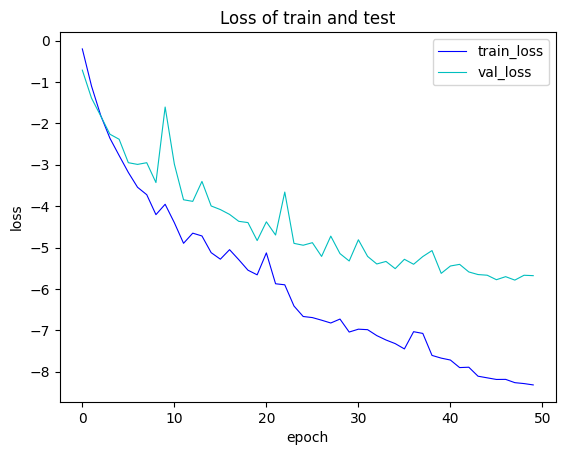

In [7]:
trainer.run(train_loader, val_loader)

During training the model exhibited a consistent and smooth decrease in the loss value, indicating stable convergence. The loss function used negative **Scale-Invariant Signal-to-Noise Ratio (SI-SNR)** is inherently **negative** because it is defined as the negative of the actual SI-SNR value in decibels (dB). This is done to turn the maximization of SI-SNR into a minimization problem.

# Testing

In [16]:
DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

def normalize_audio(audio_tensor):
    audio_np = audio_tensor.detach().cpu().numpy()
    max_val = np.max(np.abs(audio_np))
    if max_val > 0:
        audio_np /= max_val
    return audio_np

def play_pred_audio(model, mixed, sample_rate):
    with torch.no_grad():
        print(f"Mixed audio:")
        display(Audio(mixed.numpy(), rate=sample_rate))
        est_sources = model(mixed)
        
        for i, est in enumerate(est_sources):
            est = est.squeeze(0).cpu()
            est = normalize_audio(est)
            print(f"Estimated source {i+1}:")
            display(Audio(est, rate=sample_rate))

In [14]:
weights = torch.load("./Conv-TasNet-checkpoints/best.pt", map_location=torch.device(DEVICE))
model = ConvTasNet(**test_opt['net_conf'])
model.load_state_dict(weights["model_state_dict"])
model

ConvTasNet(
  (encoder): Conv1D(1, 512, kernel_size=(16,), stride=(8,))
  (LayerN_S): CumulativeLayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (BottleN_S): Conv1D(512, 128, kernel_size=(1,), stride=(1,))
  (separation): Sequential(
    (0): Sequential(
      (0): Conv1D_Block(
        (conv1x1): Conv1D(128, 512, kernel_size=(1,), stride=(1,))
        (PReLU_1): PReLU(num_parameters=1)
        (norm_1): GlobalLayerNorm()
        (dwconv): Conv1D(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), groups=512)
        (PReLU_2): PReLU(num_parameters=1)
        (norm_2): GlobalLayerNorm()
        (Sc_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
      )
      (1): Conv1D_Block(
        (conv1x1): Conv1D(128, 512, kernel_size=(1,), stride=(1,))
        (PReLU_1): PReLU(num_parameters=1)
        (norm_1): GlobalLayerNorm()
        (dwconv): Conv1D(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), groups=512)
        (PReLU_2): PReLU(num_parameters=1)


For evaluation, I used the same metrics as those reported in the original Conv-TasNet paper: **Scale-Invariant Signal-to-Noise Ratio (SI-SNR)** and **Signal-to-Distortion Ratio improvement (SDRi)**.

As mentioned earlier, **SI-SNR** measures the perceptual quality of the separated signals in a scale-invariant manner, while **SDRi** quantifies the improvement in signal quality compared to the original mixture. Specifically, **SDRi** is defined as the difference in SDR between the estimated sources and the mixed input, reflecting how much distortion the model has removed during separation.

In [12]:
test_set  = ConvTasNetMixDataset(root_dir="mix_dataset", split="test", sample_rate=8000)
test_loader = DataLoader(test_set, batch_size=1)

In [17]:
play_pred_audio(model, test_loader.dataset[0]['mix'], sample_rate)

Mixed audio:


Estimated source 1:


Estimated source 2:


In [18]:
play_pred_audio(model, test_loader.dataset[1]['mix'], sample_rate)

Mixed audio:


Estimated source 1:


Estimated source 2:


In [19]:
trainer = Trainer(model, inference=True)

In [20]:
sisnr, sdri = trainer.eval(test_loader)

100%|██████████| 1000/1000 [00:49<00:00, 20.16it/s]


In [21]:
print(f"SI-SNRi: {sisnr:.2f}dB")
print(f"SDRi:    {sdri:.2f}dB")

SI-SNRi: 7.35dB
SDRi:    6.08dB


After training, my model achieved an **SI-SNRi of 7.35 dB** and an **SDRi of 6.08 dB** on the test set. In comparison, the original Conv-TasNet paper reports **SI-SNRi of 15.3 dB** and **SDRi of 15.6 dB** when trained on the full WSJ0-2mix dataset for 100 epochs.

While the performance gap is noticeable, it is important to highlight two major constraints in my setup that likely contributed to this difference:

1. **Reduced training duration** – My model was trained for only 50 epochs, whereas the original implementation was trained for 100 epochs, allowing significantly more optimization.
2. **Smaller training dataset** – The total duration of my training data was approximately 6 times smaller than the original WSJ0-2mix dataset (around 5.5 hours vs about 30 hours).